In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = "data/mnist/"

In [4]:
!ls {PATH}

labels.csv  sample_submission.csv  test.csv  train.csv


### Data preparation

In [5]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')

In [6]:
# create labels df
# label_df = train['label']
label_df = train.iloc[:,:1]

# remove labels from training data
del train['label']
# img_df = train.iloc[:,1:]     # train.drop(labels = ["label"],axis = 1)

In [7]:
# labels = pd.DataFrame(label_df)
label_df.insert(0,'fnames', range(0, len(label_df)))
# label_df.to_csv(f'{PATH}labels.csv', index=False)

In [ ]:
# view images w/ labels
i = 0
img = train.iloc[i].values.reshape(28,28)
plt.imshow(img)
plt.title(label_df[i])

In [ ]:
# check count distributions
# normal distribution, looks good
label_df.hist()

In [ ]:
# Check for null or missing values
label_df.isnull().any().describe()
train.isnull().any().describe()

In [ ]:
# Normalize the data -> currently in grayscale.  we only need black/white (binary)
# train = train.applymap(lambda x: 1 if x>0 else 0)
# test = test.applymap(lambda x: 1 if x>0 else 0)

In [19]:
# Reshape 28 x 28 arrays
train_imgs = train.values.reshape(-1, 28, 28)
test_imgs = test.values.reshape(-1, 28, 28)

In [29]:
label_df.loc[3]['label']

4

In [24]:
# Create jpgs in train/
os.makedirs(f'{PATH}train/', exist_ok=True)

for i in range(0,len(train_imgs)):
    img = train_imgs[i][:]
    # img = img.reshape(28,28)
    img = np.stack((img,)*3,axis = -1)
    img = np.uint8(img)
    Image.fromarray(img).save(f'{PATH}train/' + str(i) + '.jpg', 'JPEG')

In [25]:
# Create jpgs in test/
os.makedirs(f'{PATH}test/', exist_ok=True)

for i in range(0,len(test_imgs)):
    img = test_imgs[i][:]
#     img = img.reshape(28,28)
    img = np.stack((img,)*3,axis = -1)
    img = np.uint8(img)
    Image.fromarray(img).save(f'{PATH}test/' + str(i) + '.jpg', 'JPEG')

Text(0.5,1,'9')

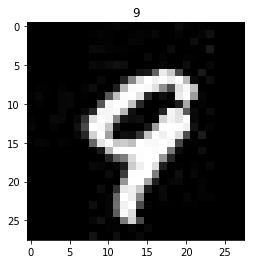

In [32]:
i = 33
img = plt.imread(f'{PATH}train/{i}.jpg')
plt.imshow(img)
plt.title(label_df.loc[i]['label'])

## Training

In [4]:
bs = 256
sz = 28
arch = resnet34

In [5]:
label_path = f'{PATH}labels.csv'
n = len(list(open(label_path)))-1
val_idxs = get_cv_idxs(n)

In [6]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_path, bs=bs, tfms=tfms, val_idxs=val_idxs,
                                        suffix='.jpg', test_name='test')
    return data

In [7]:
data = get_data(sz,bs)

In [8]:
learn = ConvLearner.pretrained(arch, data)

In [38]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▍| 125/132 [00:18<00:01,  6.82it/s, loss=21.9]

In [43]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

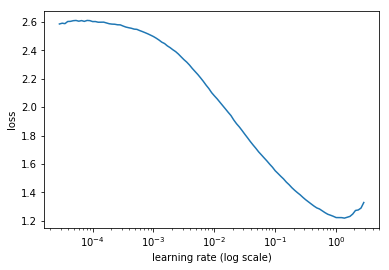

In [39]:
learn.sched.plot()

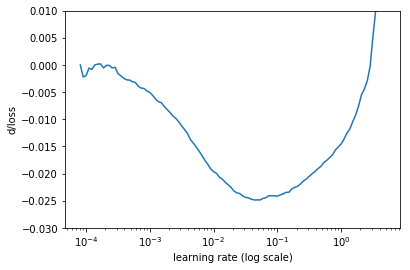

In [48]:
plot_loss_change(learn.sched, sma=20, y_lim=(-0.03,0.01))

In [52]:
lr = 0.06

In [53]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  5%|▍         | 6/132 [00:01<00:32,  3.84it/s, loss=2.61]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch:   0, train_loss: 0.581197, val_loss: 0.464370, accuracy: 0.845699
epoch:   1, train_loss: 0.466647, val_loss: 0.383328, accuracy: 0.875819
epoch:   2, train_loss: 0.409144, val_loss: 0.352779, accuracy: 0.882949



In [57]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch:   0, train_loss: 0.291917, val_loss: 0.273719, accuracy: 0.906195
epoch:   1, train_loss: 0.291938, val_loss: 0.254986, accuracy: 0.913034
epoch:   2, train_loss: 0.273230, val_loss: 0.253383, accuracy: 0.912560
epoch:   3, train_loss: 0.291355, val_loss: 0.265509, accuracy: 0.908271
epoch:   4, train_loss: 0.282247, val_loss: 0.252523, accuracy: 0.914035
epoch:   5, train_loss: 0.266676, val_loss: 0.242451, accuracy: 0.916821
epoch:   6, train_loss: 0.258019, val_loss: 0.245023, accuracy: 0.916703
epoch:   7, train_loss: 0.273944, val_loss: 0.256664, accuracy: 0.911677
epoch:   8, train_loss: 0.273553, val_loss: 0.237795, accuracy: 0.921493
epoch:   9, train_loss: 0.264603, val_loss: 0.243242, accuracy: 0.915811
epoch:  10, train_loss: 0.260684, val_loss: 0.231970, accuracy: 0.920218
epoch:  11, train_loss: 0.247239, val_loss: 0.233888, accuracy: 0.921283
epoch:  12, train_loss: 0.246347, val_loss: 0.229162, accuracy: 0.922294
epoch:  13, train_loss: 0.244056, val_loss: 0.22961

In [58]:
learn.save('resnet34_v1_48')

In [9]:
learn.load('resnet34_v1_48')

In [10]:
log_preds,y = learn.TTA(is_test=True)

In [12]:
probs = np.mean(np.exp(log_preds),0)

In [24]:
choices = np.argmax(probs, axis=1)
# Returns the indices of the maximum values along an axis

In [25]:
choices

array([6, 3, 0, ..., 5, 3, 7])

In [13]:
data.test_ds.fnames

['test/9885.jpg',
 'test/2701.jpg',
 'test/16454.jpg',
 'test/17137.jpg',
 'test/16733.jpg',
 'test/20677.jpg',
 'test/18697.jpg',
 'test/14175.jpg',
 'test/11231.jpg',
 'test/2964.jpg',
 'test/17718.jpg',
 'test/26049.jpg',
 'test/17201.jpg',
 'test/10651.jpg',
 'test/25799.jpg',
 'test/8302.jpg',
 'test/3656.jpg',
 'test/146.jpg',
 'test/25846.jpg',
 'test/2383.jpg',
 'test/20635.jpg',
 'test/13589.jpg',
 'test/8375.jpg',
 'test/12209.jpg',
 'test/2759.jpg',
 'test/7196.jpg',
 'test/22988.jpg',
 'test/6623.jpg',
 'test/15521.jpg',
 'test/27634.jpg',
 'test/12861.jpg',
 'test/9046.jpg',
 'test/19712.jpg',
 'test/15954.jpg',
 'test/23805.jpg',
 'test/3139.jpg',
 'test/22577.jpg',
 'test/2993.jpg',
 'test/19847.jpg',
 'test/14849.jpg',
 'test/7106.jpg',
 'test/1597.jpg',
 'test/7190.jpg',
 'test/15056.jpg',
 'test/19846.jpg',
 'test/4406.jpg',
 'test/21536.jpg',
 'test/11664.jpg',
 'test/9112.jpg',
 'test/12505.jpg',
 'test/19119.jpg',
 'test/26493.jpg',
 'test/27412.jpg',
 'test/16843.

In [28]:
df = pd.DataFrame(choices)
df.insert(0, 'ImageId', [(int(o[5:-4])+1) for o in data.test_ds.fnames])
df.columns = ["ImageId", "Label"]

In [37]:
df = df.sort_index(by=['ImageId'])

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [38]:
df.head()

,ImageId,Label
14168,1,2
16120,2,0
16961,3,9
9328,4,0
19253,5,3


In [40]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
filename = 'subm_v1.csv'
df.to_csv(f'{SUBM}{filename}', index=False)

In [42]:
# submit to kaggle via cli
! kg submit {SUBM+filename} -c digit-recognizer

0.96371
